## Process ERA5 regions ##

For each DNO region, process the daily max wind gust and total precipitation, 
to visualise alongside the fault data for each DNO region.

In [1]:
import os
import sys
import glob

import numpy as np
import iris
import cftime
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import cartopy.crs as ccrs
import shapely.geometry
import cartopy.io.shapereader as shpreader

# Specific imports
from tqdm import tqdm
from typing import List, Tuple, Dict, Any, Optional
from datetime import datetime, timedelta
from scipy.stats import pearsonr, linregress
from mpl_toolkits.axes_grid1 import make_axes_locatable

# standard libraries
from pathlib import Path

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# Set up the path to all of the files
wg_files_path = "/gws/nopw/j04/canari/users/benhutch/ERA5/SOTCES/ERA5_EU_SOTCES_202*_*_wind_gust.nc"

# Load in the cubes
cubes = iris.load(wg_files_path, "fg10")

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/loading.py:582: IrisLoadWarning: Not all file objects were parsed correctly. See iris.loading.LOAD_PROBLEMS for details.
  warnings.warn(message, category=IrisLoadWarning)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/netcdf/loader.py:233: IrisLoadWarning: NetCDF variable `expver` is a variable length type of kind <class 'str'> thus the total data size cannot be known in advance. This may affect the lazy loading of the data.
  warnings.warn(msg, category=iris.warnings.IrisLoadWarning)


In [3]:
cubes

[<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 672; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 744; latitude: 153; longitude: 301)>,
<iris 'Cube' of Maximum 10 metre wind gust since previous post-processing / (m s**-1) (time: 720; latitude: 153; longitude: 301)>]

In [4]:
shapefile_paths = {
    "DNO": Path("/home/users/benhutch/energy-sotcr-2024-2025/shapes_and_masks/DNOs/DNO_License_Areas_20240503_latlon.shp")
}

In [5]:
# Read in NESO's DNO shapefile with geopandas
dno_shapes = gpd.read_file(shapefile_paths["DNO"])

In [6]:
# print the head of the df
print("DNO Shapes DataFrame:")
print(dno_shapes.head())

DNO Shapes DataFrame:
                                            geometry
0  MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5...
1  POLYGON ((0.26688 52.81243, 0.26698 52.81218, ...
2  POLYGON ((-0.24419 51.48844, -0.24509 51.48926...
3  MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53....
4  POLYGON ((-1.95899 53.21664, -1.95676 53.21383...


In [7]:
# Expanded DNO Shapes DataFrame
expanded_dno_shapes = pd.DataFrame({
    "ID": [10, 11, 12, 13, 14, 15, 16, 17, 19, 21, 22, 23, 18, 20],
    "Name": ["_A", "_B", "_C", "_D", "_E", "_F", "_G", "_P", "_J", "_K", "_L", "_M", "_N", "_H"],
    "DNO": ["UKPN", "NGED", "UKPN", "SPEN", "NGED", "NPG", "ENWL", "SSEN", "UKPN", "NGED", "NGED", "NPG", "SPEN", "SSEN"],
    "Area": [
        "East England", "East Midlands", "London", "North Wales, Merseyside and Cheshire",
        "West Midlands", "North East England", "North West England", "North Scotland",
        "South East England", "South Wales", "South West England", "Yorkshire",
        "South and Central Scotland", "Southern England"
    ],
    "DNO_Full": [
        "UK Power Networks", "National Grid Electricity Distribution", "UK Power Networks",
        "SP Energy Networks", "National Grid Electricity Distribution", "Northern Powergrid",
        "Electricity North West", "Scottish and Southern Electricity Networks", "UK Power Networks",
        "National Grid Electricity Distribution", "National Grid Electricity Distribution",
        "Northern Powergrid", "SP Energy Networks", "Scottish and Southern Electricity Networks"
    ],
})

# Print the expanded DataFrame
print("Expanded DNO Shapes DataFrame:")
print(expanded_dno_shapes)

# add these columns to the dno_shapes GeoDataFrame
for col in expanded_dno_shapes.columns:
    if col not in dno_shapes.columns:
        dno_shapes[col] = expanded_dno_shapes[col].values

Expanded DNO Shapes DataFrame:
    ID Name   DNO                                  Area  \
0   10   _A  UKPN                          East England   
1   11   _B  NGED                         East Midlands   
2   12   _C  UKPN                                London   
3   13   _D  SPEN  North Wales, Merseyside and Cheshire   
4   14   _E  NGED                         West Midlands   
5   15   _F   NPG                    North East England   
6   16   _G  ENWL                    North West England   
7   17   _P  SSEN                        North Scotland   
8   19   _J  UKPN                    South East England   
9   21   _K  NGED                           South Wales   
10  22   _L  NGED                    South West England   
11  23   _M   NPG                             Yorkshire   
12  18   _N  SPEN            South and Central Scotland   
13  20   _H  SSEN                      Southern England   

                                      DNO_Full  
0                            UK Po

In [8]:
dno_shapes.head()

,geometry,ID,Name,DNO,Area,DNO_Full
0,"MULTIPOLYGON (((0.87474 51.51298, 0.87656 51.5...",10,_A,UKPN,East England,UK Power Networks
1,"POLYGON ((0.26688 52.81243, 0.26698 52.81218, ...",11,_B,NGED,East Midlands,National Grid Electricity Distribution
2,"POLYGON ((-0.24419 51.48844, -0.24509 51.48926...",12,_C,UKPN,London,UK Power Networks
3,"MULTIPOLYGON (((-4.25501 53.38796, -4.2556 53....",13,_D,SPEN,"North Wales, Merseyside and Cheshire",SP Energy Networks
4,"POLYGON ((-1.95899 53.21664, -1.95676 53.21383...",14,_E,NGED,West Midlands,National Grid Electricity Distribution


Text(119.83491205934631, 0.5, 'Latitude')

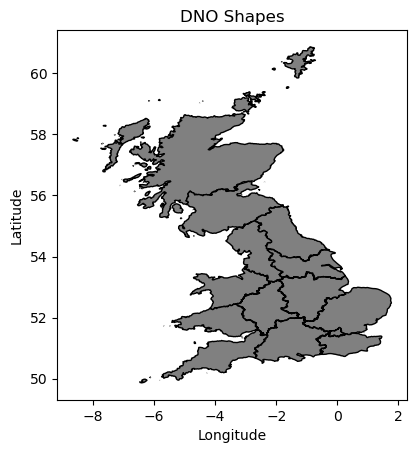

In [9]:
# Try plotting north west england first
dno_shapes.plot(
    color='grey',
    edgecolor='black',
    linewidth=1,
)
plt.title("DNO Shapes")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

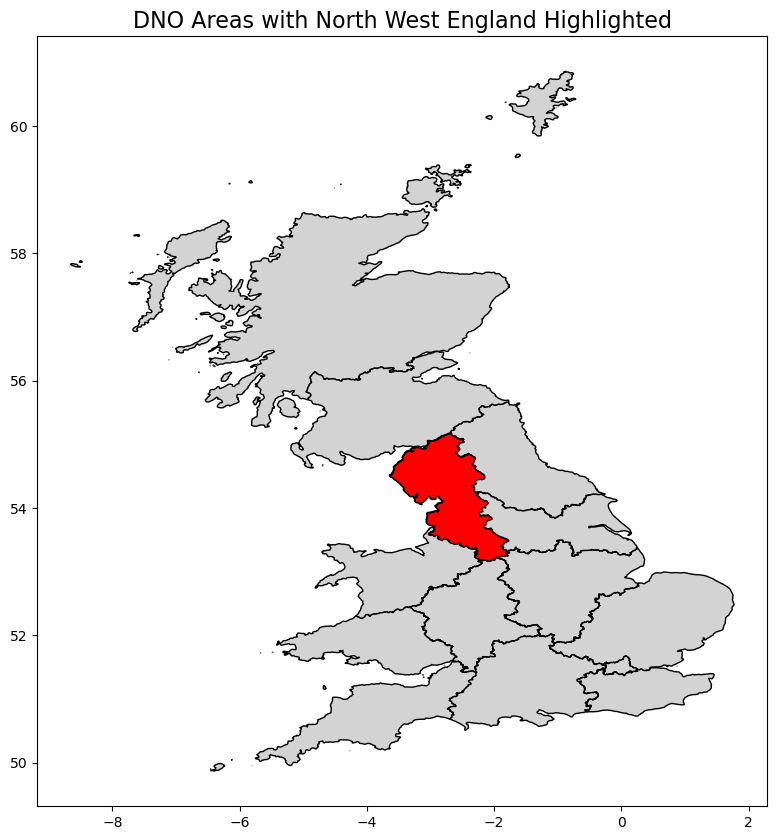

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Filter the GeoDataFrame for "North West England"
north_west_england = dno_shapes[dno_shapes["DNO"] == "ENWL"]

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
dno_shapes.plot(ax=ax, color="lightgrey", edgecolor="black")  # Plot all areas in light grey
north_west_england.plot(ax=ax, color="red", edgecolor="black")  # Highlight North West England in red

# Add title and labels
ax.set_title("DNO Areas with North West England Highlighted", fontsize=16)
plt.show()

In [11]:
# %%time

# # Set up the lons and lats
# lons = cube.coord('longitude').points
# lats = cube.coord('latitude').points

# # extract the time points
# time_points = cube.coord('time').points

# # Set up the x, y
# x, y = lons, lats

# # extract the values of the cube
# values_fg10 = cube.data

# # # print the lons and lats
# # print(f"Longitude points: {x}")
# # print(f"Latitude points: {y}")
# # # Set up the time points
# # print(f"Time points: {time_points}")

In [12]:
%%time

# Extract the lons and lats from the first cube
lons = cubes[0].coord('longitude').points
lats = cubes[0].coord('latitude').points

# Set up an empty list to hold the dfs
dfs_wind_gust = []

# Loop through the cubes and extract the data
for cube in tqdm(cubes):
    # Extract the time points
    time_points = cube.coord('time').points

    # Extract the values of the cube
    values_fg10 = cube.data

    # Set up an empty dataframe wih the time points as the index
    df = pd.DataFrame(index=(time_points))

    # Loop over the rows in dno_shapes and extract the values for each DNO
    for index, row in dno_shapes.iterrows():
        mask_matrix_this = np.zeros(
            (len(time_points),
                len(lats),
                len(lons)),
        )

        # Loop over the lats and lons
        for i, lat in enumerate(lats):
            for j, lon in enumerate(lons):
                point = shapely.geometry.Point(lons[j], lats[i])  # Replace 'l' with 'i'
                if row.geometry.contains(point):
                    # Extract the time series for this point
                    time_series_this_point = values_fg10[:, i, j]  # Replace 'l' with 'i'
                    # Add the time series to the mask matrix
                    mask_matrix_this[:, i, j] = time_series_this_point

        # Reshape the mask matrix into a time series by finding the max
        # value at each time point
        mask_matrix_this_max = np.max(mask_matrix_this, axis=(1, 2))

        # Add the time series to the dataframe
        df[row["Area"]] = mask_matrix_this_max

    # Append the dataframe to the list
    dfs_wind_gust.append(df)

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [01:50<00:00,  8.53s/it]

CPU times: user 1min 39s, sys: 4.94 s, total: 1min 44s
Wall time: 1min 50s


In [13]:
dfs_wind_gust[0].head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
1711929600,5.918596,11.392228,2.930315,10.759416,9.441056,13.986955,14.412736,12.590470,10.076798,10.310197,8.810197,12.737931,11.925431,8.440080
1711933200,5.454466,10.771849,4.167357,10.269896,8.377317,13.869505,14.226927,12.709349,9.716185,9.734739,8.619505,12.326536,12.968138,8.307981
1711936800,6.199211,10.352531,5.716789,10.206047,8.068352,14.336906,14.049797,13.022453,10.431633,8.965813,7.131828,12.317375,12.763664,7.894523
1711940400,6.990768,9.764206,6.633346,10.100143,8.081589,14.274948,13.846237,13.535690,10.727097,8.258347,6.338424,12.395065,13.652878,7.938034
1711944000,7.247946,9.493064,7.439353,9.699119,7.802634,13.029197,13.045798,14.207908,10.676658,7.018454,6.414938,12.077048,14.197165,7.993063


In [14]:
# Loop over the dfs wind gust
for i, df in enumerate(dfs_wind_gust):
    # Set the index to a datetime index
    df.index = pd.to_datetime(df.index, unit='s', origin='1970-01-01')

In [15]:
dfs_wind_gust[0].tail()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-04-30 19:00:00,9.061892,10.684938,7.786501,9.957399,9.209352,11.905642,11.784548,16.152712,8.277712,10.150759,7.647829,10.902712,13.543337,8.288454
2024-04-30 20:00:00,8.567490,9.116318,5.998153,8.653427,7.580184,11.583115,9.367294,15.374130,7.908309,9.373154,7.133895,9.596786,11.885849,7.679794
2024-04-30 21:00:00,7.667079,9.017666,6.423915,8.131924,6.992275,10.496181,8.141689,14.362392,8.209072,8.794033,6.858486,8.888760,11.282314,7.697353
2024-04-30 22:00:00,7.114398,7.814593,6.576312,7.392718,6.327289,8.937640,7.659320,13.449359,8.353656,8.062640,6.987445,8.597796,10.464007,7.762836
2024-04-30 23:00:00,7.206179,7.415163,6.534304,6.713015,6.122194,8.098757,6.771608,13.299929,8.228640,7.413210,7.338991,7.778444,9.302858,7.202272


In [16]:
# Join the dataframes together on the index
df_wind_gust = pd.concat(dfs_wind_gust, axis=0)

In [17]:
# Sort the index of these
df_wind_gust = df_wind_gust.sort_index()

In [18]:
df_wind_gust.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2024-04-01 00:00:00,5.918596,11.392228,2.930315,10.759416,9.441056,13.986955,14.412736,12.590470,10.076798,10.310197,8.810197,12.737931,11.925431,8.440080
2024-04-01 01:00:00,5.454466,10.771849,4.167357,10.269896,8.377317,13.869505,14.226927,12.709349,9.716185,9.734739,8.619505,12.326536,12.968138,8.307981
2024-04-01 02:00:00,6.199211,10.352531,5.716789,10.206047,8.068352,14.336906,14.049797,13.022453,10.431633,8.965813,7.131828,12.317375,12.763664,7.894523
2024-04-01 03:00:00,6.990768,9.764206,6.633346,10.100143,8.081589,14.274948,13.846237,13.535690,10.727097,8.258347,6.338424,12.395065,13.652878,7.938034
2024-04-01 04:00:00,7.247946,9.493064,7.439353,9.699119,7.802634,13.029197,13.045798,14.207908,10.676658,7.018454,6.414938,12.077048,14.197165,7.993063


In [19]:
# Set up the fname for this
fname = "max_10m_wind_gusts_timeseries_DNO_areas_Apr_2024-Apr_2025.csv"

# Set up the directory in which to save this
output_dir = Path("/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs")

# Make the directory if it doesn't exist
output_dir.mkdir(parents=True, exist_ok=True)

# if the full path does not exist
if not os.path.exists(os.path.join(output_dir, fname)):
    # Save the dataframe to a csv file
    df_wind_gust.to_csv(os.path.join(output_dir, fname))

### Plot the wind gust for the year ###

And also mark the storms on this as well

In [20]:
# Process the dataframe to take the max value for each day
df_wind_gust_daily_max = df_wind_gust.resample('D').max()

In [21]:
# Print the columns of the dataframe
print("Columns in the DataFrame:")
print(df_wind_gust_daily_max.columns)

Columns in the DataFrame:
Index(['East England', 'East Midlands', 'London',
       'North Wales, Merseyside and Cheshire', 'West Midlands',
       'North East England', 'North West England', 'North Scotland',
       'South East England', 'South Wales', 'South West England', 'Yorkshire',
       'South and Central Scotland', 'Southern England'],
      dtype='object')


In [ ]:
# Set up a dictionary for the storms ordered by date
storms = {
    "Storm Henk": ["2024-01-02", "2024-01-02"],
    "Storm Isha": ["2024-01-19", "2024-01-22"],
    "Storm Jocelyn": ["2024-01-22", "2024-01-24"],
    "Storm Kathleen": ["2024-04-04", "2024-04-07"],
    "Storm Lilian": ["2024-08-22", "2024-08-23"],
    "Storm Ashley": ["2024-10-18", "2024-10-21"],
    "Storm Bert": ["2024-11-21", "2024-11-25"],
    "Storm Conall": ["2024-11-26", "2024-11-27"],
    "Storm Darragh": ["2024-12-05", "2024-12-07"],
    "Storm Éowyn": ["2025-01-21", "2025-01-24"],
}

# Set up different colours for the storms (ordered to match)
storm_colours = {
    "Storm Henk": "cyan",
    "Storm Isha": "magenta",
    "Storm Jocelyn": "yellow",
    "Storm Kathleen": "brown",
    "Storm Lilian": "pink",
    "Storm Ashley": "red",
    "Storm Bert": "blue",
    "Storm Conall": "green",
    "Storm Darragh": "purple",
    "Storm Éowyn": "orange",
}

region_colors = {
    'East England': 'tab:blue',
    'East Midlands': 'tab:orange',
    'London': 'tab:green',
    'North Wales, Merseyside and Cheshire': 'tab:red',
    'West Midlands': 'tab:purple',
    'North East England': 'tab:brown',
    'North West England': 'tab:pink',
    'North Scotland': 'tab:gray',
    'South East England': 'tab:olive',
    'South Wales': 'tab:cyan',
    'South West England': 'gold',
    'Yorkshire': 'teal',
    'South and Central Scotland': 'navy',
    'Southern England': 'magenta'
}

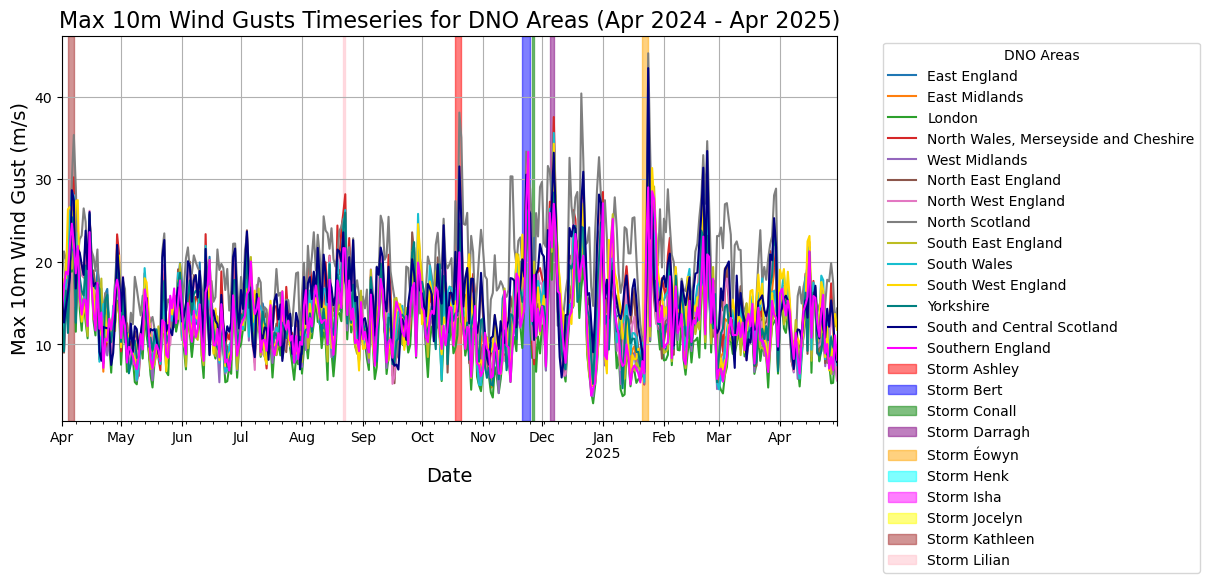

In [26]:
# Set up the figure
fig, ax = plt.subplots(figsize=(10, 5))

# Loop over the columns in the dataframe
for col in df_wind_gust_daily_max.columns:
    # Plot the data for this column
    df_wind_gust_daily_max[col].plot(
        ax=ax,
        label=col,
        color=region_colors.get(col, 'black'),  # Use black if the region is not in the colors dict
        linewidth=1.5
    )

# Loop through the storms and plot the time periods
for storm, dates in storms.items():
    start_date = pd.to_datetime(dates[0]).tz_localize(None)  # Make timezone-naive
    end_date = pd.to_datetime(dates[1]).tz_localize(None)    # Make timezone-naive

    plt.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)


# Set the title and labels
ax.set_title("Max 10m Wind Gusts Timeseries for DNO Areas (Apr 2024 - Apr 2025)", fontsize=16)
ax.set_xlabel("Date", fontsize=14)
ax.set_ylabel("Max 10m Wind Gust (m/s)", fontsize=14)
ax.legend(title="DNO Areas", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
ax.grid(True)


In [27]:
# From the daily max for each DNO area, find the max value for each day across all DNO areas
df_wind_gust_daily_max_overall = df_wind_gust_daily_max.max(axis=1)

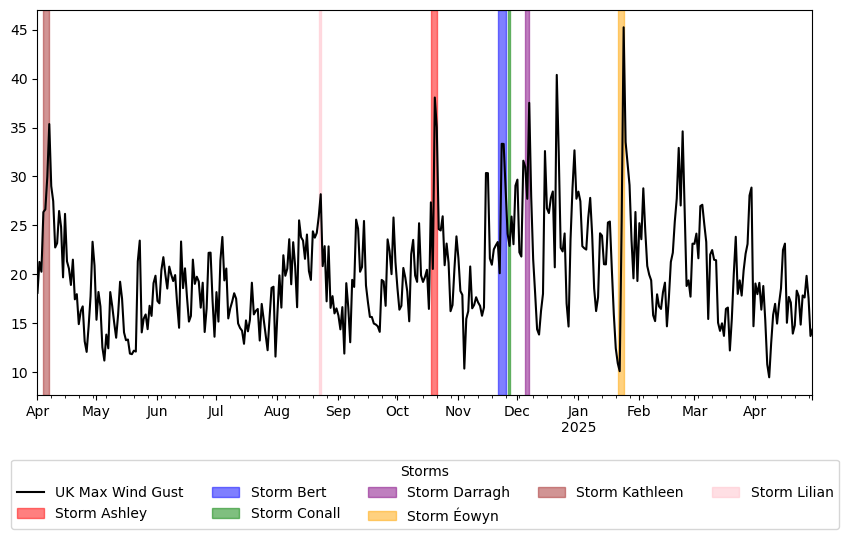

In [34]:
# Plot the overall max wind gusts
fig, ax = plt.subplots(figsize=(10, 5))

df_wind_gust_daily_max_overall.plot(
    ax=ax,
    label="UK Max Wind Gust",
    color='black',
    linewidth=1.5
)

# If the storms are within the date range of the dataframe, plot them
for storm, dates in storms.items():
    if pd.to_datetime(dates[0]).tz_localize(None) >= df_wind_gust_daily_max_overall.index.min() and \
       pd.to_datetime(dates[1]).tz_localize(None) <= df_wind_gust_daily_max_overall.index.max():
        start_date = pd.to_datetime(dates[0]).tz_localize(None)
        end_date = pd.to_datetime(dates[1]).tz_localize(None)
        plt.axvspan(start_date, end_date, color=storm_colours[storm], alpha=0.5, label=storm)


# Include the legend horizontally beneath the plot
ax.legend(title="Storms", bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=5, fontsize=10)

In [ ]:
import shapely.geometry

# Set up an empty dataframe with time_points as the index
dataframe_full = pd.DataFrame(index=(time_points))

# print the head of the dataframe full
print("DataFrame Full:")
print(dataframe_full.head())

# sys.exit()

# Loop over the rows in dno_shapes and extract time series for each DNO area
for index, row in tqdm(dno_shapes.iterrows(), total=len(dno_shapes)):
    # if index > 0:
    #     print("MAsk matrix this DNO")
    #     print(mask_matrix_this_dno)

    #     # print the number of non-zero values in the mask matrix
    #     print(f"Number of non-zero values in mask matrix for DNO {row['DNO']}: {np.count_nonzero(mask_matrix_this_dno)}")

    #     # print the number of zero values in the mask matrix
    #     print(f"Number of zero values in mask matrix for DNO {row['DNO']}: {np.size(mask_matrix_this_dno) - np.count_nonzero(mask_matrix_this_dno)}")

    #     # print the shape of the mask matrix
    #     print(f"Shape of mask matrix for DNO {row['DNO']}: {mask_matrix_this_dno.shape}")

    #     # Reshape the mask matrix into a time series by finding the max value at each time point
    #     time_series_max = np.max(mask_matrix_this_dno, axis=(1, 2))

    #     # Print the resulting time series shape
    #     print(f"Shape of time series: {time_series_max.shape}")

    #     # pritn the time series max values
    #     print(f"Time series max values for DNO {row['DNO']}: {time_series_max}")

    #     sys.exit("Skipping all but the first DNO for now, as this is a test run.")

    mask_matrix_this_dno = np.zeros((len(time_points), len(lats), len(lons)))

    for l in range(len(lats)):
        for j in range(len(lons)):
            point = shapely.geometry.Point(lons[j], lats[l])
            if row.geometry.contains(point):
                # Extract the time series for this point
                time_series_this_point = values_fg10[:, l, j]
                # Add the time series to the mask matrix
                mask_matrix_this_dno[:, l, j] = time_series_this_point

    # Reshape the mask matrix into a time series by finding the max value at each time point
    time_series_max = np.max(mask_matrix_this_dno, axis=(1, 2))
    # Add the time series to the dataframe
    dataframe_full[row['Area']] = time_series_max


DataFrame Full:
Empty DataFrame
Columns: []
Index: [1735689600, 1735693200, 1735696800, 1735700400, 1735704000]


 14%|█▍        | 2/14 [00:01<00:07,  1.51it/s]

100%|██████████| 14/14 [00:09<00:00,  1.50it/s]


In [ ]:
dataframe_full.head()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
1735689600,21.790569,22.408733,20.229046,28.179241,21.928265,18.558147,18.694866,23.394085,22.347210,23.442913,20.486858,21.567913,20.033733,20.811077
1735693200,21.978304,22.712679,20.181429,28.451937,21.692171,18.090609,23.522249,23.335726,22.374788,23.245882,20.948030,22.240023,19.907015,21.140413
1735696800,22.127405,26.467249,19.950647,26.727991,21.581507,17.827600,25.434046,22.613733,22.144007,23.651819,21.429163,22.724085,19.141077,21.442835
1735700400,22.102224,22.977224,19.935232,26.342459,22.049490,17.006521,19.739920,22.535818,21.965506,24.385427,21.887381,22.745779,19.057302,21.730154
1735704000,21.453869,22.574963,20.183361,25.779064,22.900158,16.528088,21.873791,22.356213,22.116955,26.324963,22.396252,22.924572,19.617931,22.530041


In [ ]:
# print the statistics of the dataframe
print("DataFrame Full Statistics:")
print(dataframe_full.describe())

DataFrame Full Statistics:
       East England  East Midlands      London  \
count    744.000000     744.000000  744.000000   
mean      10.544734      10.049373    7.681281   
std        5.105902       4.815721    5.281354   
min        2.870171       2.067924    1.587949   
25%        6.712028       6.439429    3.785991   
50%        8.970361       9.227954    5.883409   
75%       13.039875      12.199191    9.371973   
max       28.169748      29.761381   24.483469   

       North Wales, Merseyside and Cheshire  West Midlands  \
count                            744.000000     744.000000   
mean                              11.409827       8.834709   
std                                5.251432       4.836341   
min                                2.353966       2.431005   
25%                                7.400197       5.186902   
50%                               10.652082       7.502181   
75%                               14.231668      11.105107   
max                       

In [ ]:
# convert the index to datetime
# valid_time:units = "seconds since 1970-01-01" ;
dataframe_full.index = pd.to_datetime(dataframe_full.index, unit='s', origin='1970-01-01')

In [ ]:
dataframe_full.tail()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2025-01-31 19:00:00,6.835136,3.936698,3.004081,3.841972,4.395683,2.839042,2.624198,10.308768,7.116386,4.113456,5.100761,2.643730,3.498222,5.225761
2025-01-31 20:00:00,6.569185,3.937349,3.416841,3.094575,3.616060,3.576997,2.535982,11.650240,6.335786,3.653169,5.135591,2.968599,3.794771,5.193208
2025-01-31 21:00:00,6.140099,3.560997,4.144981,2.353966,3.193810,3.798302,3.395958,13.399864,6.879356,3.443810,5.037560,2.861778,4.207481,5.270958
2025-01-31 22:00:00,6.523525,2.941494,4.355556,2.790126,2.716884,4.554775,3.754970,14.096766,7.962978,3.302822,5.001064,2.080165,4.902431,5.319423
2025-01-31 23:00:00,6.511625,2.795805,4.010649,3.433501,2.592680,5.108305,4.269438,15.434477,8.598539,3.625883,4.863188,2.333891,5.613188,5.195219


In [ ]:
# Maximum 10 metre wind gust

# Set up the directory in which to save this
output_dir = Path("/home/users/benhutch/energy-sotcr-2024-2025/saved_dfs")

# Set up the fname
fname_this = "max_10m_wind_gust_timeseries_dno_areas.csv"

# if the full path does not exist, then save it
if not os.path.exists(os.path.join(output_dir, fname_this)):
    print(f"Saving dataframe to {os.path.join(output_dir, fname_this)}")
    dataframe_full.to_csv(os.path.join(output_dir, fname_this))

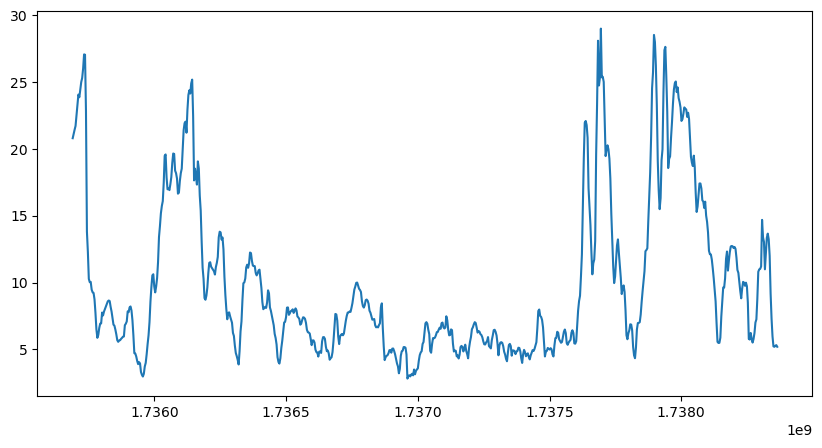

In [ ]:
# plot the time series max
plt.figure(figsize=(10, 5))

plt.plot(time_points, time_series_max, label=f"DNO {row['DNO']}")

Now do the same but for accumulated daily precipitation during January 2025

In [ ]:
# precip path
nov_precip_path = "/home/users/benhutch/energy-sotcr-2024-2025/ben_test_data/Jan/data_stream-oper_stepType-accum.nc"
dec_precip_path = "/home/users/benhutch/energy-sotcr-2024-2025/ben_test_data/Feb/data_stream-oper_stepType-accum.nc"
jan_precip_path = "/home/users/benhutch/energy-sotcr-2024-2025/ben_test_data/Dec/data_stream-oper_stepType-accum.nc"
feb_precip_path = "/home/users/benhutch/energy-sotcr-2024-2025/ben_test_data/Nov/data_stream-oper_stepType-accum.nc"
mar_precip_path = "/home/users/benhutch/energy-sotcr-2024-2025/ben_test_data/Mar/data_stream-oper_stepType-accum.nc"

# create a list of cubes
precip_paths = [
    nov_precip_path,
    dec_precip_path,
    jan_precip_path,
    feb_precip_path,
    mar_precip_path
]

# load multiple cubes
cubes = iris.load(precip_paths, "tp")

/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/loading.py:582: IrisLoadWarning: Not all file objects were parsed correctly. See iris.loading.LOAD_PROBLEMS for details.
  warnings.warn(message, category=IrisLoadWarning)
/home/users/benhutch/.conda/envs/bens-conda-env2/lib/python3.11/site-packages/iris/fileformats/netcdf/loader.py:233: IrisLoadWarning: NetCDF variable `expver` is a variable length type of kind <class 'str'> thus the total data size cannot be known in advance. This may affect the lazy loading of the data.
  warnings.warn(msg, category=iris.warnings.IrisLoadWarning)


In [ ]:
# print the min and max time of the second last cube and last cube
print(f"Second last cube time range: {cubes[-2].coord('time').points.min()} to {cubes[-2].coord('time').points.max()}")
print(f"Last cube time range: {cubes[-1].coord('time').points.min()} to {cubes[-1].coord('time').points.max()}")

Second last cube time range: 1740787200 to 1743462000
Last cube time range: 1738368000 to 1740783600


In [ ]:
print(cubes_concat.concatenate())

0: Total precipitation / (m)           (time: 744; latitude: 153; longitude: 301)
1: Total precipitation / (m)           (time: 744; latitude: 153; longitude: 301)
2: Total precipitation / (m)           (time: 720; latitude: 153; longitude: 301)
3: Total precipitation / (m)           (time: 744; latitude: 153; longitude: 301)
4: Total precipitation / (m)           (time: 672; latitude: 153; longitude: 301)


In [ ]:
# extract the time points of the final cube
time_points_precip = cubes[-1].coord('time').points

# convert the time points to datetime
time_points_precip = pd.to_datetime(time_points_precip, unit='s', origin='1970-01-01')

# print the min and max of these
print(f"Time points precip min: {time_points_precip.min()}")
print(f"Time points precip max: {time_points_precip.max()}")

Time points precip min: 2025-02-01 00:00:00
Time points precip max: 2025-02-28 23:00:00


In [ ]:
# %%time

# # Set up the lons and lats for the precipitation data
# lons_precip = cube_precip.coord('longitude').points
# lats_precip = cube_precip.coord('latitude').points

# # extract the time points
# time_points_precip = cube_precip.coord('time').points

# # Set up the x, y for the precipitation data
# x_precip, y_precip = lons_precip, lats_precip

# # extract the values of the cube for precipitation
# values_tp = cube_precip.data

CPU times: user 365 ms, sys: 88.6 ms, total: 454 ms
Wall time: 607 ms


In [ ]:
%%time

# extrcat the lons of the first cube
lons_precip = cubes[0].coord('longitude').points
lats_precip = cubes[0].coord('latitude').points

# set up an empty list to hold the dfs
dataframes_precip = []

# loop over the cubes
for cube_precip in cubes:
    # Extract the time points this
    time_points_precip_this = cube_precip.coord('time').points

    # extract the values thi
    values_tp_this = cube_precip.data

    # Set up an empty dataframe
    dataframe_full_precip_this = pd.DataFrame(index=(time_points_precip_this))

    # Loop over the rows in dno_shapes and extract time series for each DNO area
    for index, row in tqdm(dno_shapes.iterrows(), total=len(dno_shapes)):
        mask_matrix_this_dno_precip = np.zeros((len(time_points_precip_this), len(lats_precip), len(lons_precip)))

        for l in range(len(lats_precip)):
            for j in range(len(lons_precip)):
                point = shapely.geometry.Point(lons_precip[j], lats_precip[l])
                if row.geometry.contains(point):
                    # Extract the time series for this point
                    time_series_this_point = values_tp_this[:, l, j]
                    # Add the time series to the mask matrix
                    mask_matrix_this_dno_precip[:, l, j] = time_series_this_point

        # Reshape the mask matrix into a time series by summing the values at each time point
        time_series_sum = np.sum(mask_matrix_this_dno_precip, axis=(1, 2))
        # Add the time series to the dataframe
        dataframe_full_precip_this[row['Area']] = time_series_sum

    # Append the dataframe to the list
    dataframes_precip.append(dataframe_full_precip_this)

100%|██████████| 14/14 [00:09<00:00,  1.55it/s]

CPU times: user 45.4 s, sys: 2.02 s, total: 47.5 s
Wall time: 48.1 s


In [ ]:
# loop over the dataframes precip
for i, df in enumerate(dataframes_precip):
    # convert all columns from m to mm
    dataframes_precip[i] = df * 1000  # Convert from meters to millimeters

    # Convert the index to datetime
    dataframes_precip[i].index = pd.to_datetime(dataframes_precip[i].index, unit='s', origin='1970-01-01')

In [ ]:
dataframes_precip[4]

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2025-02-01 00:00:00,0.116348,0.146866,0.003815,0.016212,0.152588,0.062943,0.061989,0.337601,0.006676,0.003815,0.001907,0.114441,0.052452,0.153542
2025-02-01 01:00:00,0.105858,0.173569,0.000477,0.086308,0.108719,0.038147,0.174046,0.262737,0.025749,0.005722,0.011921,0.122070,0.054359,0.125408
2025-02-01 02:00:00,0.072002,0.239372,0.000000,0.025749,0.290871,0.075817,0.201225,0.099659,0.029087,0.006676,0.012398,0.092506,0.030518,0.056267
2025-02-01 03:00:00,0.052929,0.402451,0.000000,0.024319,0.621319,0.267029,0.097275,0.085354,0.043869,0.002861,0.062466,0.083447,0.013828,0.092030
2025-02-01 04:00:00,0.024319,0.284672,0.000000,0.010490,0.180244,0.143528,0.122547,0.093937,0.047684,0.016212,0.051498,0.122547,0.012875,0.357628
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-28 19:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008583,0.807285,0.000000,0.000000,0.003338,0.000000,0.010967,0.000000
2025-02-28 20:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002861,1.479149,0.000000,0.000000,0.002861,0.000000,0.001907,0.000000
2025-02-28 21:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001431,1.395226,0.000000,0.000000,0.000477,0.000000,0.001431,0.000000
2025-02-28 22:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000954,0.000000,1.621246,0.000477,0.000000,0.000000,0.000000,0.001431,0.000000


In [ ]:
# join the dataframes together on the index
dataframe_full_precip = pd.concat(dataframes_precip, axis=0)

In [ ]:
dataframe_full_precip.tail()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2025-02-28 19:00:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.008583,0.807285,0.000000,0.0,0.003338,0.0,0.010967,0.0
2025-02-28 20:00:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.002861,1.479149,0.000000,0.0,0.002861,0.0,0.001907,0.0
2025-02-28 21:00:00,0.0,0.0,0.0,0.0,0.0,0.000000,0.001431,1.395226,0.000000,0.0,0.000477,0.0,0.001431,0.0
2025-02-28 22:00:00,0.0,0.0,0.0,0.0,0.0,0.000954,0.000000,1.621246,0.000477,0.0,0.000000,0.0,0.001431,0.0
2025-02-28 23:00:00,0.0,0.0,0.0,0.0,0.0,0.002384,0.000000,3.742218,0.001431,0.0,0.000000,0.0,0.009060,0.0


In [ ]:
# order the index correctly as time from oldest to newest
dataframe_full_precip = dataframe_full_precip.sort_index()

In [ ]:
dataframe_full_precip.tail()

,East England,East Midlands,London,"North Wales, Merseyside and Cheshire",West Midlands,North East England,North West England,North Scotland,South East England,South Wales,South West England,Yorkshire,South and Central Scotland,Southern England
2025-03-31 19:00:00,0.0,0.0,0.0,0.001907,0.0,0.0,0.0,0.139713,0.0,0.0,0.0,0.0,0.003338,0.0
2025-03-31 20:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.034809,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-31 21:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.024319,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-31 22:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.007629,0.0,0.0,0.0,0.0,0.000000,0.0
2025-03-31 23:00:00,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000477,0.0,0.0,0.0,0.0,0.000000,0.0


In [ ]:
# Set up the fname for this
fname_this_precip = "total_precip_timeseries_dno_areas_Nov_2024-Mar_2025.csv"

# if the full path does not exist, then save it
if not os.path.exists(os.path.join(output_dir, fname_this_precip)):
    print(f"Saving dataframe to {os.path.join(output_dir, fname_this_precip)}")
    dataframe_full_precip.to_csv(os.path.join(output_dir, fname_this_precip))

Saving dataframe to /home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/total_precip_timeseries_dno_areas_Nov_2024-Mar_2025.csv


In [ ]:
# convert all columns from m to mm
dataframe_full_precip_mm = dataframe_full_precip * 1000  # Convert from m to mm

In [ ]:
# Convert the index to datetime
dataframe_full_precip_mm.index = pd.to_datetime(dataframe_full_precip_mm.index, unit='s', origin='1970-01-01')

In [ ]:
# Set up the fname this
fname_this_precip = "accumulated_precipitation_timeseries_dno_areas_mm_Jan_2025.csv"

# if the full path does not exist, then save it
if not os.path.exists(os.path.join(output_dir, fname_this_precip)):
    print(f"Saving dataframe to {os.path.join(output_dir, fname_this_precip)}")
    dataframe_full_precip_mm.to_csv(os.path.join(output_dir, fname_this_precip))

Saving dataframe to /home/users/benhutch/energy-sotcr-2024-2025/saved_dfs/accumulated_precipitation_timeseries_dno_areas_mm_Jan_2025.csv
